In [22]:
import gdal
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,f1_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn import tree, svm, naive_bayes,neighbors
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier,  GradientBoostingClassifier

In [49]:
def getBands(filename):
    img = gdal.Open(filename)
    bands = []
    for i in range(img.RasterCount):
        band = img.GetRasterBand(i+1).ReadAsArray().astype(np.float)
        bands.append(band)
    bands = np.dstack((bands[0],bands[1],bands[2],bands[3]))
    return bands
def maxminNorm(data):
    '''
    01标准化
    '''
    data=data.astype(np.float32)
    dmax=data.max()
    dmin=data.min()
    return (data-data.min())/(dmax-dmin)

def index(data,ind="NDVI"):
    '''
    input:原始数据，默认保持影像形状，默认计算NDVI
    returns:相应指数
    '''
    nir=data[:,:,3]
    red=data[:,:,2]
    grn=data[:,:,1]
    blue=data[:,:,0]
    if ind=="NDVI":# 归一化植被指数 
        NDVI=(nir-red)/(nir+red+1e-8)
        return NDVI
    elif ind=="NDWI":# 归一化水体指数
        NDWI=(grn-nir)/(grn+nir+1e-8)
        return NDWI
    elif ind=="CIg":# 叶绿素指数-绿边 
        CIg=nir/(grn+1e-8)-1
        return CIg
    elif ind=="EVI":# 增强型植被指数 
        EVI=2.5*(nir-red)/(nir+ 6*red-7.5*blue+1+1e-8)
        return EVI
    elif ind=="GNDVI":# 绿光归一化差值植被指数
        GNDVI = (nir - grn)/(nir + grn+1e-8)
        return GNDVI
    elif ind=="MSAVI":# 修正土壤调节植被指数
        MSAVI=0.5*(2*(nir +1)-np.sqrt((2*nir+1)**2-8*(nir-red)))
        return MSAVI
    elif ind=="MTVI":# 修正型三角植被指数
        MTVI=1.5*(1.2*(nir-grn)-2.5*(red-grn))/np.sqrt((2*nir+1)**2-(6*nir-5*np.sqrt(red))-0.5)
        return MTVI
    elif ind=="SAVI":# 土壤调节植被指数
        L=0.5
        SAVI=((nir-red)/(nir+red+L))*(1+L)
        return SAVI
    elif ind=="VARI":# 可视化大气阻抗指数
        VARI=(grn-red)/(grn+red-blue+1e-8)
        return VARI
    
def returnLabeldata(data,indexName,df=False,reshape=True,norm=False):
    h,w,d=data.shape
    dataIdx=np.zeros((data.shape[0],data.shape[1],len(indexName)),dtype=np.float32)
    for i,idx in enumerate(indexName):
        if norm==True:
            dataIdx[:,:,i]=maxminNorm(index(data,ind=idx))
        else:
            dataIdx[:,:,i]=index(data,ind=idx)
    if len(np.unique(np.argwhere(np.isnan(dataIdx))[:,2]))!=0:
        print(np.unique(np.argwhere(np.isnan(dataIdx))[:,2]))
    if df==True:
        res=pd.DataFrame(dataIdx.reshape((h*w,-1)),columns=indexName)
    if reshape==True:
        res=dataIdx.reshape((h*w,-1))
    else:
        res=dataIdx
    return res

def addY(loc,data,nums):#data3维
    loc=loc.astype(np.int)
    y=np.array([0]*nums[0]+[1]*nums[1]+[2]*nums[2]+[3]*nums[3]+[4]*nums[4]).reshape((sum(nums),1))
    x=np.zeros((sum(nums),data.shape[2]))
    for i,yx in enumerate(loc):
        x[i,:]=data[yx[1],yx[0],:]
    train=np.concatenate((x,y),axis=1)
    return train

def cotrain(datadf,x1,y1,x2,y2,model1,model2,size=50):
    model1.fit(x1,y1.ravel())
    model2.fit(x2,y2.ravel())
    # 候选预测数据概率和标签
    datadf['prob1']=model1.predict_proba(datadf[features1]).max(axis=1)
    datadf['prob2']=model2.predict_proba(datadf[features2]).max(axis=1)
    datadf['guessClass1']=model1.predict(datadf[features1])
    datadf['guessClass2']=model2.predict(datadf[features2])
    # 找到guessclass一致区域的数据
    datadf_candidate=datadf[datadf['change1']==0][datadf['guessClass1']==datadf['guessClass2']]
    # 标签一致区域找到置信度最高的区域
    class_candidate=[datadf_candidate[datadf_candidate['guessClass1']==i] for i in range(5)]
    # 找到两期置信度都高的区域更新训练集
    sizes=[size,size//2,size//3,size//2,size//10]
    for i in range(5):
        index1=np.array(class_candidate[i].sort_values(by="prob1" , ascending=False).index)
        index2=np.array(class_candidate[i].sort_values(by="prob2" , ascending=False).index)
        can1=index1[:sizes[i]]
        can2=index2[:sizes[i]]
        x1=np.concatenate((x1,class_candidate[i].loc[can1,features1]),axis=0)
        x2=np.concatenate((x2,class_candidate[i].loc[can2,features2]),axis=0)
        y1=np.concatenate((y1,class_candidate[i].loc[can1,['guessClass1']].values.reshape((-1,1))),axis=0)
        y2=np.concatenate((y2,class_candidate[i].loc[can2,['guessClass2']].values.reshape((-1,1))),axis=0)
    return x1,y1,x2,y2,model1,model2

def run(datadf,x1,y1,x2,y2,model1,model2,x_test1,y_test1,x_test2,y_test2,size=50,epoch=20):
    score1,score2=[],[]
    for i in range(epoch):
        x1,y1,x2,y2,model1,model2=cotrain(datadf,x1,y1,x2,y2,model1,model2,size)
        y_pre1 = model1.predict(x_test1)
        y_pre2 = model2.predict(x_test2)
        f1=f1_score(y_test1, y_pre1, average='weighted')
        f2=f1_score(y_test2, y_pre2, average='weighted')
        print("score: f1:%.5f f2:%.5f"%(f1,f2))
        score1.append(f1)
        score2.append(f2)
    return model1,model2,score1,score2

def selectSample(x,y,sample):
    m=np.zeros((sample*5),dtype=np.int)
    for i in range(5):
        m[i*sample:(i+1)*sample]=np.random.randint(i*200,(i+1)*200,size=sample)
    return x[m,:],y[m,:]    

def color(y_pred):
    y_pred=y_pred.reshape((653,772))
    show=np.zeros((653,772,3))
    cmap=np.array([[0,255,0],[255,255,0],[0,0,255],[255,0,0],[0,255,255]])
    for i in range(5):
        show[y_pred==i,:]=cmap[i]
    return show

In [3]:
# prepare data
path=r"E:\project\images\sentinal"
img1=getBands(os.path.join(path,"170805.tif"))
img2=getBands(os.path.join(path,"190919.tif"))
data1=img1
data2=img2
indexName=["NDVI","NDWI","MSAVI","MTVI","VARI"]
labdata1=returnLabeldata(data1,indexName,reshape=False,norm=True)
labdata2=returnLabeldata(data2,indexName,reshape=False,norm=True)
data1norm=maxminNorm(data1)
data2norm=maxminNorm(data2)
data1total=np.concatenate((data1norm,labdata1),axis=2)
data2total=np.concatenate((data2norm,labdata2),axis=2)

In [4]:
# load label
label1=np.loadtxt(open(r"E:\project\images\sentinal\process\label\label17.csv","r"),delimiter=',',skiprows=25,dtype=np.int)
label2=np.loadtxt(open(r"E:\project\images\sentinal\process\label\label19.csv","r"),delimiter=',',skiprows=25,dtype=np.int)
loc1=label1[:,:2]
loc2=label2[:,:2]
train1=addY(loc1,data1total,[200,200,200,200,200])
train2=addY(loc2,data2total,[200,200,200,200,200])

In [5]:
# prepare mask
mask=cv2.imread(r"E:\project\images\sentinal\process\label\mask.tif",0)
#unmask=cv2.imread(r"E:\project\images\sentinal\process\label\unmask.tif",0)
unmask=np.ones((mask.shape[0],mask.shape[1]))-mask
mask=mask.ravel()
unmask=unmask.ravel()
data1reshape=data1total.reshape((-1,data1total.shape[2]))
data2reshape=data2total.reshape((-1,data2total.shape[2]))

In [6]:
#初始化数据
features1=['blue1','grn1','red1','nir1','NDVI1','NDWI1','MSAVI1','MTVI1','VARI1']
features2=['blue2','grn2','red2','nir2','NDVI2','NDWI2','MSAVI2','MTVI2','VARI2']
data1df=pd.DataFrame(data1reshape,columns=features1)
data2df=pd.DataFrame(data2reshape,columns=features2)
data1df['change1']=unmask
data2df['change2']=unmask
data1df['row1']=np.array([i//772 for i in range(data1df.shape[0])])
data1df['col1']=np.array([i%772 for i in range(data1df.shape[0])])
data2df['row2']=np.array([i//772 for i in range(data2df.shape[0])])
data2df['col2']=np.array([i%772 for i in range(data2df.shape[0])])
data1df['prob1']=np.zeros((data1df.shape[0]))
data2df['prob2']=np.zeros((data2df.shape[0]))
data1df['guessClass1']=np.zeros((data1df.shape[0]))-1
data2df['guessClass2']=np.zeros((data2df.shape[0]))-1
data1df['acceptClass1']=np.zeros((data1df.shape[0]))-1
data2df['acceptClass2']=np.zeros((data2df.shape[0]))-1
datadf=pd.concat([data1df,data2df],axis=1)

In [7]:
# 准备数据
x1=train1[:,:-1]
y1=train1[:,-1:]
x2=train2[:,:-1]
y2=train2[:,-1:]

In [8]:
# load label
lab1=np.loadtxt(open(r"E:\project\images\sentinal\process\label\test17.csv","r"),delimiter=',',skiprows=25,dtype=np.int)
lab2=np.loadtxt(open(r"E:\project\images\sentinal\process\label\test19.csv","r"),delimiter=',',skiprows=25,dtype=np.int)
testloc1=lab1[:,:2]
testloc2=lab2[:,:2]
test1=addY(testloc1,data1total,[1000,1000,800,1000,200])
test2=addY(testloc2,data2total,[1000,1000,800,1000,200])
x_test1 = test1[:,:-1]
y_test1 = test1[:,-1]
x_test2 = test2[:,:-1]
y_test2 = test2[:,-1]

In [38]:
# 测试模型
#model1=BaggingClassifier(neighbors.KNeighborsClassifier(),n_estimators=50, max_samples=0.5,max_features=0.5)
#model2=BaggingClassifier(neighbors.KNeighborsClassifier(),n_estimators=50, max_samples=0.5,max_features=0.5)
model1=RandomForestClassifier(n_estimators=50)
#model1=GradientBoostingClassifier(n_estimators=50)
#model1=VotingClassifier(estimators=[("rfs_clf", RFS1),("gbc_clf", GBC1)],voting='soft')
model2=RandomForestClassifier(n_estimators=50)
#model2=GradientBoostingClassifier(n_estimators=50)
#model2=VotingClassifier(estimators=[("rfs_clf", RFS2),("gbc_clf", GBC2)],voting='soft')
model1.fit(x1,y1.ravel())
model2.fit(x2,y2.ravel())
y_pre1 = model1.predict(x_test1)
y_pre2 = model2.predict(x_test2)
f1=f1_score(y_test1, y_pre1, average='weighted')
f2=f1_score(y_test2, y_pre2, average='weighted')
print("%.5f %.5f"%(f1,f2))

0.81381 0.88216


In [57]:
# 构造model训练
scores1=[]
scores2=[]
for i in range(10):
    print("%d epoch"%i)
    model1=RandomForestClassifier(n_estimators=50)
    model2=RandomForestClassifier(n_estimators=50)
    x_train1,y_train1=selectSample(x1,y1,(i+1)*20)
    x_train2,y_train2=selectSample(x2,y2,(i+1)*20)
    model1,model2,score1,score2=run(datadf,x_train1,y_train1,x_train2,y_train2,model1,model2,x_test1,y_test1,x_test2,y_test2,size=20,epoch=20)
    y_pred1=model1.predict(data1reshape).astype(np.int)
    show1=color(y_pred1)
    cv2.imwrite(r"E:\project\images\sentinal\process\output\cotrain\sample"+str((i+1)*20)+"epoch20size20class17.tif",show1)
    y_pred2=model2.predict(data2reshape).astype(np.int)
    show2=color(y_pred2)
    cv2.imwrite(r"E:\project\images\sentinal\process\output\cotrain\sample"+str((i+1)*20)+"epoch20size20class19.tif",show2)
    scores1.append(score1)
    scores2.append(score2)

0 epoch


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.74383 f2:0.81734


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.74928 f2:0.78897


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.74631 f2:0.81184


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.74367 f2:0.81459


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.75061 f2:0.81580


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.75594 f2:0.81294


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.75933 f2:0.80974


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.73924 f2:0.81943


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.75573 f2:0.80505


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.75067 f2:0.81753


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.74817 f2:0.81231


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.75533 f2:0.81525


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.76249 f2:0.81998


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.75668 f2:0.81485


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.75108 f2:0.81244


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.75198 f2:0.80844


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.75671 f2:0.80362


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.75321 f2:0.81707


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.74872 f2:0.81383


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.74110 f2:0.81223
1 epoch


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79272 f2:0.85491


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79880 f2:0.85062


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78774 f2:0.83675


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77900 f2:0.83430


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78837 f2:0.85574


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80032 f2:0.82680


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80486 f2:0.83955


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79135 f2:0.83078


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79919 f2:0.83069


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78310 f2:0.84376


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77757 f2:0.83121


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78233 f2:0.82502


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77523 f2:0.83961


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79560 f2:0.84845


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79083 f2:0.86344


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79438 f2:0.83580


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77712 f2:0.84593


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78401 f2:0.84405


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77624 f2:0.83643


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.76976 f2:0.83041
2 epoch


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77069 f2:0.86837


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78040 f2:0.86578


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78583 f2:0.84670


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78133 f2:0.85839


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80132 f2:0.84306


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78311 f2:0.85342


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77702 f2:0.85030


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77436 f2:0.85984


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78212 f2:0.83987


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77813 f2:0.83974


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77831 f2:0.83018


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77656 f2:0.86325


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.76920 f2:0.82671


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77810 f2:0.85562


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77666 f2:0.85016


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78033 f2:0.84732


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79354 f2:0.84412


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77223 f2:0.85479


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.76758 f2:0.84104


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79148 f2:0.86110
3 epoch


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80712 f2:0.86499


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80499 f2:0.86519


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80557 f2:0.85332


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80471 f2:0.86211


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79793 f2:0.85768


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78940 f2:0.85231


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79439 f2:0.86209


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78580 f2:0.85365


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78660 f2:0.86124


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78505 f2:0.85168


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77595 f2:0.86062


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78041 f2:0.84947


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78616 f2:0.86229


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79749 f2:0.85748


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79637 f2:0.85090


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78472 f2:0.86448


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.76803 f2:0.86064


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78781 f2:0.85708


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77494 f2:0.85773


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77198 f2:0.85756
4 epoch


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80344 f2:0.84549


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79867 f2:0.84441


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80793 f2:0.84482


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78431 f2:0.84231


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80686 f2:0.84117


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.81065 f2:0.84143


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.81319 f2:0.84413


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80033 f2:0.83493


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79176 f2:0.84044


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80672 f2:0.83857


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80302 f2:0.84147


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80252 f2:0.83727


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78430 f2:0.83784


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78262 f2:0.83899


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78476 f2:0.84158


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80525 f2:0.84687


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79539 f2:0.83420


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80670 f2:0.84394


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80578 f2:0.83933


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79920 f2:0.84105
5 epoch


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78544 f2:0.85906


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77964 f2:0.85677


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78238 f2:0.85541


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79266 f2:0.85215


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78204 f2:0.85194


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.76913 f2:0.84984


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77636 f2:0.85717


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77283 f2:0.84480


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78037 f2:0.85611


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77930 f2:0.85597


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77502 f2:0.85472


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77611 f2:0.85447


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77847 f2:0.85478


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78485 f2:0.84569


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77359 f2:0.84780


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77856 f2:0.83792


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78193 f2:0.83980


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77935 f2:0.86248


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78135 f2:0.84149


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77792 f2:0.83622
6 epoch


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80294 f2:0.86542


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.81326 f2:0.86574


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80669 f2:0.87139


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78542 f2:0.86613


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78523 f2:0.86862


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78529 f2:0.86258


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77866 f2:0.86144


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78961 f2:0.86809


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77576 f2:0.86481


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77983 f2:0.86275


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79914 f2:0.87292


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78420 f2:0.87671


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77823 f2:0.86908


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78823 f2:0.87014


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77423 f2:0.86982


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78157 f2:0.87356


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77994 f2:0.86553


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79068 f2:0.87279


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78361 f2:0.87347


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77314 f2:0.86684
7 epoch


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80420 f2:0.87521


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80978 f2:0.86785


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.81223 f2:0.86898


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80025 f2:0.87487


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.81412 f2:0.87729


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80959 f2:0.87508


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78710 f2:0.86880


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80330 f2:0.87884


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.81024 f2:0.87733


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80867 f2:0.88218


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79681 f2:0.87631


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80982 f2:0.87620


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78505 f2:0.87096


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80813 f2:0.86933


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80570 f2:0.87242


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.81056 f2:0.86947


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80398 f2:0.88211


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.81277 f2:0.87813


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80793 f2:0.87571


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80327 f2:0.87616
8 epoch


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80388 f2:0.87647


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80328 f2:0.88169


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.81638 f2:0.88044


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79732 f2:0.86519


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.81110 f2:0.87809


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80982 f2:0.88060


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78897 f2:0.87744


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80285 f2:0.88531


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78747 f2:0.87946


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78977 f2:0.88536


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78951 f2:0.87662


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78804 f2:0.88491


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78680 f2:0.87967


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80977 f2:0.87906


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80363 f2:0.88183


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78693 f2:0.88513


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80033 f2:0.88067


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78557 f2:0.87461


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80571 f2:0.87626


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80396 f2:0.87530
9 epoch


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78898 f2:0.85045


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78879 f2:0.85360


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80088 f2:0.84953


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.80828 f2:0.84567


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79167 f2:0.85579


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78877 f2:0.85146


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78570 f2:0.85053


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78670 f2:0.85918


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78598 f2:0.85214


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78255 f2:0.84363


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78224 f2:0.85203


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78537 f2:0.85185


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78744 f2:0.86324


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78321 f2:0.85688


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.79461 f2:0.85482


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78187 f2:0.85165


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78222 f2:0.85245


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.77989 f2:0.84763


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78656 f2:0.85127


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


score: f1:0.78900 f2:0.85374


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 771.5, 652.5, -0.5)

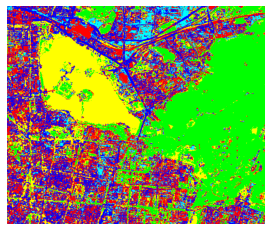

In [79]:
y_pred1=model1.predict(data1reshape).astype(np.int)
show1=color(y_pred1)
#cv2.imwrite(r"E:\project\images\sentinal\process\output\epoch20size20class17.jpg",show1)
plt.imshow(show1)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 771.5, 652.5, -0.5)

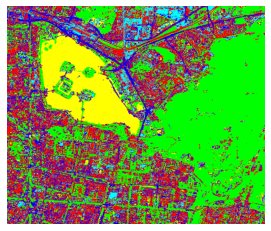

In [77]:
y_pred2=model2.predict(data2reshape).astype(np.int)
show2=color(y_pred2)
#cv2.imwrite(r"E:\project\images\sentinal\process\output\epoch20size20class19.jpg",show2)
plt.imshow(show2)
plt.axis('off')

In [80]:
def conv(y_pred,hsize,wsize):
    h,w=653,772
    src=y_pred.copy()
    src=src.reshape((h,w))
    for i in range(h//hsize):
        for j in range(w//wsize):
            src[i*hsize:(i+1)*hsize,j*wsize:(j+1)*wsize]=np.histogram(src[i*hsize:(i+1)*hsize,j*wsize:(j+1)*wsize].ravel(),[0,1,2,3,4,5])[0].argmax()
    return src

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


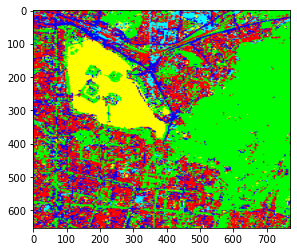

In [87]:
tmp=conv(y_pred2,2,4)
tmo=conv(tmp,4,2)
plt.imshow(color(tmp))

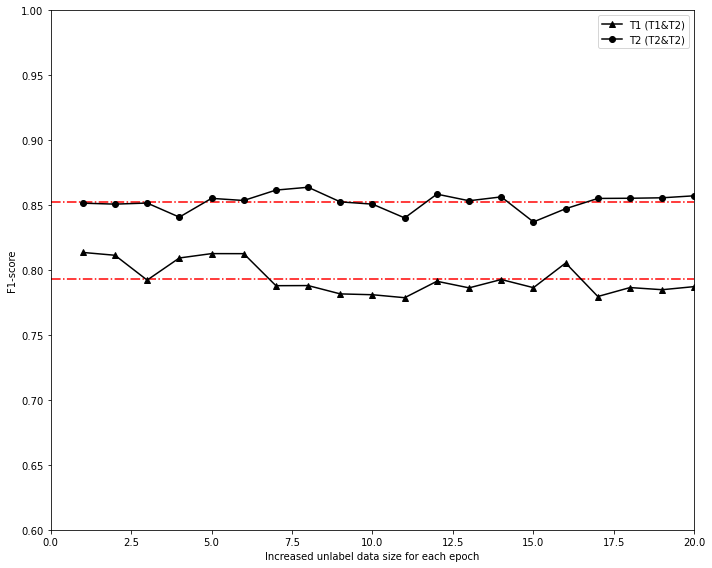

In [56]:
epochs=list(range(1,21))
plt.figure(figsize=(10,8))
plt.plot(epochs,scores1[6],color='black',marker='^',linestyle='-')
plt.plot(epochs,scores2[6],color='black',marker='o',linestyle='-')
# plt.plot(epochs,score1,color='black',marker='^',linestyle='--')
# plt.plot(epochs,score2,color='black',marker='o',linestyle='--')
f1m=np.array(scores1[6]).mean()
f2m=np.array(scores2[6]).mean()
plt.hlines(f1m, 0, 20, colors = "red", linestyles = "-.")
plt.hlines(f2m, 0, 20, colors = "r", linestyles = "-.")
plt.ylim(0.6,1)
plt.xlim(0,20)
plt.ylabel('F1-score')
plt.xlabel("Increased unlabel data size for each epoch")
plt.legend(['T1 (T1&T2)','T2 (T2&T2)'])
plt.tight_layout()
#plt.savefig(r"E:\project\images\researchImage\HR\output\f1scoreSize10Epoch100.jpg")
plt.show()